Note : このノートブックでは **Python 3.11.0^ カーネル と g4dn.xlarge インスタンス** を使ってください。

# ユースケース
このラボでは、合成衛星画像を生成します。これらの画像は研究のために使われたり、画像認識モデルを作成するときの入力画像として利用されます。

# Stable Diffusion

Stable Diffusion を利用すると、簡単にテキストから画像を生成することができます。画像生成以外にも、別の画像とプロンプトに基づいて画像を生成したり（image to image）、インペインティング（画像の一部を編集）、アウトペインティング（画像を拡張）、アップスケーリング（画像の解像度を大きくする）などの機能を備えています。

## なぜ Stable Diffusion を Fine-tune するのか？

Stable Diffusion は画像生成において優れていますが、特定の分野に特化した画像の質はあまり高くないかもしれません。たとえば、このノートブックでは、衛星画像を生成しようとします。デフォルトで生成される衛生画像は、いくつかの特徴（高速道路など）をよく表していますが、高速道路を含む衛生画像の品質を向上させるために、実際の衛生画像を用いて Stable Diffusion を Fine-tuning します。

## Fine-tuneの方法

Stable Diffusion を Fine-tune するために、[こちら](https://dreambooth.github.io/) で説明のある DtreamBooth という方法を使います。以下は、DreamBooth の論文の簡単な説明です。
> 私たちの方法では、被写体（例えば特定の犬）の数枚の画像（実験において、通常 3 ~ 5 枚の画像で十分です）と、対応するクラス名（例えば"犬"）を入力とし、固有の被写体に関する一意の識別子をエンコードする Fine-tuneされた/パーソナライズされた text-to-imageモデル を得ます。推論では、異なる文章による一意の識別子を異なるコンテキストの被写体の合成に埋め込むことができます。

**さあ、はじめましょう!**
ハードウェアに関するステップを最初に行います。ノートブックの最初に記載している、正しいカーネルとインスタンスのサイズが選択されていることを確認してください。


In [2]:
!nvidia-smi

Thu Mar  6 08:59:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   22C    P8              8W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

次に、このノートブックで必要ないくつかのライブラリをインストールします。

In [3]:
!pip install transformers accelerate>=0.20.3 ftfy tensorboard Jinja2 huggingface_hub==0.25.2 wandb kaggle git+https://github.com/huggingface/diffusers@v0.18.0 --upgrade

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-bzafwlid
  Running command git checkout -q 9506ef0490bfec4dbfdf86af4e166eb3cbf226e9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.2 requires nvidia-ml-py3==7.352.0, which is not installed.
autogluon-multimodal 1.2 requires accelerate<1.0,>=0.34.0, but you have accelerate 1.4.0 which is incompatible.
autogluon-multimodal 1.2 requires jsonschema<4.22,>=4.18, but you have jsonschema 4.23.0 which is incompatible.
autogluon-multimodal 1.2 requires nltk<3.9,>=3.4.5, but you have nltk 3.9.1 which is incompatible.
autogluon-multimodal 1.2 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-timeseries 1.2 requires accelerate<1.0,>=0.34.0, but you have accelerate 1.4.0 which is incompatible

### データセット
このチュートリアルのために、Sentinal 2 Satellite 画像からなる、土地利用のための分類データセットである EuroSAT データセットを使います。生成する衛星画像のタイプとして、`Highway`クラスを使用します。`Forest` と `Industrial` クラスは、モデルが `Highway` *インスタンス*を分離する*クラス*として機能します。
ノート: このエクササイズでは、EuroSATデータセットの画像サイズに合わせて、全ての画像を 64,64 にリサイズして表示します。

In [4]:
!mkdir -p EuroSAT/Highway
!unzip -q eurosat-dataset.zip "EuroSAT/Highway/*" -d ""

replace EuroSAT/Highway/Highway_1807.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
!mkdir -p EuroSAT/base/Forest
!unzip -q eurosat-dataset.zip "EuroSAT/Forest/*" -d "base"

In [6]:
!mkdir -p EuroSAT/base/Industrial
!unzip -q eurosat-dataset.zip "EuroSAT/Industrial/*" -d "base"

## データセットの観察
EuroSAT データセットの `Highway` クラスのデータを見てみましょう。

In [7]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

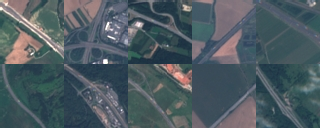

In [8]:
actual_img = [Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

`Forest` と `Industrial` クラスを見てみましょう。

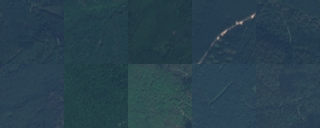

In [9]:
actual_img = [Image.open("base/EuroSAT/Forest/Forest_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

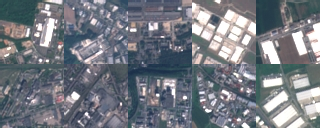

In [10]:
actual_img = [Image.open("base/EuroSAT/Industrial/Industrial_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

In [11]:
import shutil, os
forest_files = os.listdir("base/EuroSAT/Forest")
industrial_files = os.listdir("base/EuroSAT/Industrial")

In [12]:
!mkdir -p "base/class"

準備のため、Fine-tuningに使用できるパスにファイルをコピーします。

In [13]:
for filename in forest_files:
    shutil.copyfile(
        os.path.join("base/EuroSAT/Forest",filename),
        os.path.join("base/class",filename)
    )
for filename in industrial_files:
    shutil.copyfile(
        os.path.join("base/EuroSAT/Industrial",filename),
        os.path.join("base/class",filename)
    )

## Stable Diffusion を利用した画像の生成
Fine-tuningを始める前に、Stable Diffusion がデフォルトで生成する画像を見ておきます。Stable Diffusion (1.5) を使って、`Highway` クラスの衛星画像を生成します。
Haggingface の [Diffusers](https://huggingface.co/docs/diffusers/index) ライブラリを利用します。

In [14]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2025-03-06 09:01:12.778872: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 09:01:12.797193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 09:01:12.815254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 09:01:12.820865: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 09:01:12.833795: I tensorflow/core/platform/cpu_feature_guar

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.18.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [15]:
img_list = pipe(["Sentinel 2 satellite image of a highway"]*10, num_inference_steps=25).images

  0%|          | 0/25 [00:00<?, ?it/s]

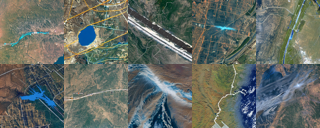

In [16]:
image_grid([x.resize((64,64)) for x in img_list], 2,5)

In [17]:
import gc
from numba import cuda
del(pipe)
gc.collect()
torch.cuda.empty_cache()

# device = cuda.get_current_device()
# device.reset()

## EuroSAT の実際の高速道路画像

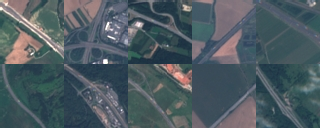

In [18]:
actual_img = [Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

Stable Diffustion が直接生成した画像と実際の EuroSAT データセットの画像とで、色やスタイルに大きな違いがあることがわかります。

## DreamBooth と LoRA を利用した Stable Diffution の Fine-tune
正しいタイプの衛星画像をどのように生成するのか学ぶため、text-to-image モデルを Fine-tune します。そのために、2 つの最近のイノベーションである、Dreambooth と LoRA を利用します。
DreamBooth はモデルがより大きな `class` と関連する明確なキャラクターをもった `instance` に適合した画像を生成することをモデルが学習するための新しい方法です。
Low rank adapters (LoRA) は学習するパラメータを大きく減少することで、モデル学習を高速にします。
[こちら](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README.md) に役に立つスクリプトがあります。

Stable Diffusion が新しい`instance`を学べるように、一意で（そして短い）トークン/単語を、新しい`instance`を表現するために使います。ここでは、文字順序として、他の意味のある単語と似ておらず、トークン/単語によく使われる `sks` を使います。`sks` は Stable Diffusion の Fine-tuningのチュートリアルでもよく使われます。

最初に、diffusers ライブラリをインストールします。

In [19]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

--2025-03-06 09:15:54--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58435 (57K) [text/plain]
Saving to: ‘train_dreambooth_lora.py.1’

train_dreambooth_lo 100%[===================>]  57.07K  --.-KB/s    in 0.001s  

2025-03-06 09:15:54 (55.9 MB/s) - ‘train_dreambooth_lora.py.1’ saved [58435/58435]



次に、Fine-tuningのコードを事項します。Fine-tuningがこのノートブックのローカルで実行されます。
[accelerate](https://github.com/huggingface/accelerate) ライブラリを使うと、PyTorchのコードを複数のGPUで簡単に実行できます。

In [20]:
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="EuroSAT/Highway" \
  --output_dir=trained_model \
  --instance_prompt="Sentinel 2 satellite image of sks" \
  --resolution=256 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --report_to="tensorboard" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --with_prior_preservation \
  --class_data_dir="base/class" \
  --class_prompt="Sentinel 2 satellite image" \
  --max_train_steps=800 \
  --seed="0" 

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-03-06 09:16:14.590335: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 09:16:14.604356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 09:16:14.622476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cu

## 結果の可視化
モデルが学習できたので、次の比較を行います。
1. Fine-tuningせずに、Stable Diffusion で生成した画像
2. LoRA と Dream Booth によって Fine-tuning された Stable Diffusion で生成した画像
3. EuroSATのオリジナル画像

In [ ]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

Fine-tuningなしで生成した画像を見てみましょう。

In [ ]:
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

In [ ]:
img_list = pipe(["Sentinel 2 satellite image of a highway"]*3, num_inference_steps=25).images
image_grid([x.resize((128,128)) for x in img_list], 1,3)

次に、Fine-tuningした後の生成画像を見てみます。

In [ ]:
pipe.unet.load_attn_procs("./trained_model/checkpoint-800")

In [ ]:
img_list = pipe(["Sentinel 2 satellite image of sks"]*3, num_inference_steps=25).images

In [ ]:
image_grid([x.resize((128,128)) for x in img_list], 1,3)

最後に、オリジナルの画像を見てみます。

In [ ]:
from PIL.ImageOps import exif_transpose
actual_img = [exif_transpose(Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i)))) for i in range(1,4)]
image_grid([x.resize((128,128)) for x in actual_img], 1,3)

これで、このノートブックは終了です。このノートブックでは、画像を利用して Stable Diffusion を Fine-tunning することで、どの程度生成画像の品質が向上するのか見てきました。

## クリーンアップ
このノートブックを閉じた後、左にある白い円の中に黒の四角があるアイコンを使って、インスタンスを停止してください。